# Correct the metadata on Cell Painting Gallery

__Author: Runxi Shen__

__Date: 2025-04-19__

This notebook aims to correct the incorrect metadata (mismatched gene allele information and well position on the 384-well plate due to robotic technical errors) for VarChAMP 1% project's Batch 13-14 on Cell Painting Gallery. The corrected metadata was provided by Tanisha and the error in this round of batches was caused by "our miniprep plates was accidentally put on the prep machine backwards"

In [37]:
import pandas as pd
import numpy as np
import os

## split the raw metadata into two parts: mut info and cell/well info
ALLELE_INFO_COLS = [
    'node_type', 'symbol','gene_allele', 'source_plate', 'source_well', 'source_numb',
    'dest_plate', 'dest_well', 'dest_numb', 'node_type', 'orf_id_wt',
    'ccsb_mutation_id', 'nt_change_cdna', 'aa_change', 'allele_set',
    'clone_ID', 'hgmd_ID', 'clinvar_allele_ID', 'clinvar_clinical_significance', #'control_type',
]
WELL_INFO_COLS = [
    'plate_map_name', 'well_position', 'imaging_well',
    'imaging_plate_R1', 'imaging_plate_R2', 'imaging_plate', 'batch1', 'batch2',
    'vector', 'notes', 'plate', 'quad', 'c96', 'r96', 'r384', 'c384', 'r384_letter'
]

## If more rows/cols need to be displayed
# For pandas
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows
# pd.set_option('display.width', None)        # Width of the display in characters
# pd.set_option('display.max_colwidth', None) # Maximum width of columns

# For polars
# pl.Config.set_tbl_rows(100)      # Number of rows to display
# pl.Config.set_tbl_cols(100)      # Number of columns to display
# pl.Config.set_fmt_str_lengths(100) # Maximum width of string columns

## Loading necessary files

### The corrected metadata


In [38]:
## Define the directory path
## The corrected metadata provided by Tanisha
## The error is caused by "our miniprep plates was accidentally put on the prep machine backwards"
data_dir = "../../inputs/corrected_metadata/batch13-14/"
correct_meta_file = "B13-14_Metadata_UpdateSeq_041025.csv"

## import the corrected metadata
meta_corrected_df = pd.read_csv(os.path.join(data_dir, correct_meta_file))
print("Corrected metadata for batch 13/14 imported with shape:", meta_corrected_df.shape)
## the 2 candidate positive controls I asked you to test, HPRT1 and KLHL3, have incorrect mutants, discarded for now:
meta_corrected_df = meta_corrected_df[~meta_corrected_df["gene"].isin(["KLHL3","HPRT1"])]
print("Corrected metadata dropped alleles from HPRT1 and KLHL3 with shape:", meta_corrected_df.shape)

## for checking name matching only, still need to KEEP ALL WELLS no matter if they have final_gene_allele or not
# print("Cleaning up gene symbols and check if they are formatted correctly:")
# meta_corrected_df_no_nan = meta_corrected_df[meta_corrected_df["final_gene_allele"].notna()].copy()
# meta_corrected_df_no_nan["final_gene"] = meta_corrected_df_no_nan["final_gene_allele"].apply(lambda x: x.split("_")[0])
# print("Final Symbol and Final Gene are the same:", all(meta_corrected_df_no_nan["final_gene"] == meta_corrected_df_no_nan["gene"]))
# print("Mismatch between Final Symbol and Final Gene:")
# display(meta_corrected_df_no_nan[meta_corrected_df_no_nan["final_gene"] != meta_corrected_df_no_nan["gene"]])
# print("Keep the final_gene_allele and final_gene for final reference.")

## process the final metadata info for reference
## remove any character that is NOT A–Za–z, 0–9, or _
meta_corrected_df['final_gene_allele'] = meta_corrected_df['final_gene_allele'].str.replace(r'[^A-Za-z0-9_]+', '', regex=True)
## grep the gene_symbol from final_gene_allele directly to avoid gene symbol and allele mismatch
meta_corrected_df["gene_symbol"] = meta_corrected_df["final_gene_allele"].apply(lambda x: x.split("_")[0] if not pd.isnull(x) else x)
## remove the tailing '_' char at the end of the gene_symbol
meta_corrected_df["final_gene_allele"] = meta_corrected_df["final_gene_allele"].str.rstrip('_')
## get the mutation's plate-well position on each platemap
meta_corrected_df["plate_well_id_b13"] = meta_corrected_df["imaging_plate_R1"] + "-" + meta_corrected_df["imaging_well"]
meta_corrected_df["plate_well_id_b14"] = meta_corrected_df["imaging_plate_R2"] + "-" + meta_corrected_df["imaging_well"]
meta_corrected_df.rename(columns={
    "imaging_plate_R1": "imaging_plate_R1_b13",
    "imaging_plate_R2": "imaging_plate_R2_b14"
}, inplace=True)

## store for reference
meta_corrected_df_original = meta_corrected_df.copy()

## generate the final metadata map for the well and allele
meta_corrected_df.drop(columns=["symbol", "gene_allele", "gene", "allele"], inplace=True)
# print(meta_corrected_df["node_type"].unique())

## check disease_wt alleles
# meta_corrected_df_wt = meta_corrected_df[meta_corrected_df["node_type"]=="disease_wt"]
# assert(all(meta_corrected_df_wt["gene_symbol"]==meta_corrected_df_wt["final_gene_allele"]))

## Need to readjust some alleles for their node type, as some alleles were misnamed as disease_wt
meta_corrected_df.loc[(meta_corrected_df["gene_symbol"]!=meta_corrected_df["final_gene_allele"])&(meta_corrected_df["node_type"]=="disease_wt"), "node_type"] = "allele"
meta_corrected_df.loc[meta_corrected_df["final_gene_allele"].isna(), "node_type"] = np.nan

meta_corrected_df_wt = meta_corrected_df[meta_corrected_df["node_type"]=="disease_wt"]
assert(all(meta_corrected_df_wt["gene_symbol"]==meta_corrected_df_wt["final_gene_allele"]))
# display(meta_corrected_df[~meta_corrected_df["final_gene_allele"].isna()])

Corrected metadata for batch 13/14 imported with shape: (714, 20)
Corrected metadata dropped alleles from HPRT1 and KLHL3 with shape: (712, 20)


In [39]:
meta_corrected_df.dropna(subset="final_gene_allele").drop_duplicates(subset="final_gene_allele").groupby("node_type").count()

,source_plate,source_well,source_numb,dest_plate,dest_well,dest_numb,imaging_well,imaging_plate_R1_b13,imaging_plate_R2_b14,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,sequencing_confidence,final_gene_allele,gene_symbol,plate_well_id_b13,plate_well_id_b14
node_type,,,,,,,,,,,,,,,,,,
NC,4,0,0,4,4,4,4,4,4,0,0,0,0,0,4,4,4,4
PC,2,0,0,2,2,2,2,2,2,0,0,0,1,0,2,2,2,2
TC,1,0,0,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1
allele,591,580,580,591,591,591,591,591,591,591,584,589,589,34,591,591,591,591
cPC,6,0,0,6,6,6,6,6,6,0,0,0,4,2,6,6,6,6
disease_wt,23,23,23,23,23,23,23,23,23,23,0,0,0,14,23,23,23,23


In [40]:
meta_corrected_df[meta_corrected_df["node_type"]=="allele"].dropna(subset="final_gene_allele").drop_duplicates(subset="final_gene_allele")

,source_plate,source_well,source_numb,dest_plate,dest_well,dest_numb,imaging_well,imaging_plate_R1_b13,imaging_plate_R2_b14,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,sequencing_confidence,final_gene_allele,gene_symbol,plate_well_id_b13,plate_well_id_b14
1,CP_CAVA_01,B01,2.0,527_CAVA_Array_P01,B01,2,C01,B13A7A8P1_R1,B14A7A8P1_R2,allele,100008637.0,CCSBVarC007022,1552C>T,Arg518Trp,NaN,ABCD1_Arg518Trp,ABCD1,B13A7A8P1_R1-C01,B14A7A8P1_R2-C01
2,CP_CAVA_01,C01,3.0,527_CAVA_Array_P01,C01,3,E01,B13A7A8P1_R1,B14A7A8P1_R2,allele,100008637.0,CCSBVarC007023,1165C>G,Arg389Gly,NaN,ABCD1_Arg389Gly,ABCD1,B13A7A8P1_R1-E01,B14A7A8P1_R2-E01
3,CP_CAVA_01,D01,4.0,527_CAVA_Array_P01,D01,4,G01,B13A7A8P1_R1,B14A7A8P1_R2,allele,100008637.0,CCSBVarC007021,1553G>A,Arg518Gln,NaN,ABCD1_Arg518Gln,ABCD1,B13A7A8P1_R1-G01,B14A7A8P1_R2-G01
5,CP_CAVA_03,B07,50.0,527_CAVA_Array_P01,F01,6,K01,B13A7A8P1_R1,B14A7A8P1_R2,allele,3760.0,CCSBVarC009473,1786A>G,Ser596Gly,NaN,BAP1_Ser596Gly,BAP1,B13A7A8P1_R1-K01,B14A7A8P1_R2-K01
6,CP_CAVA_03,C07,51.0,527_CAVA_Array_P01,G01,7,M01,B13A7A8P1_R1,B14A7A8P1_R2,allele,3760.0,CCSBVarC009476,1268C>A,Thr423Lys,NaN,BAP1_Thr423Lys,BAP1,B13A7A8P1_R1-M01,B14A7A8P1_R2-M01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,527_CCM2_P02,D09,68.0,527_CAVA_Array_P08,G03,23,N06,B13A7A8P2_R1,B14A7A8P2_R2,allele,3928.0,CCSBVarC038848,1306G>A,Gly436Ser,NaN,CCM2_Gly436Ser,CCM2,B13A7A8P2_R1-N06,B14A7A8P2_R2-N06
695,527_CCM2_P02,E09,69.0,527_CAVA_Array_P08,H03,24,P06,B13A7A8P2_R1,B14A7A8P2_R2,allele,3928.0,CCSBVarC038849,1317G>A,Met439Ile,NaN,CCM2_Met439Ile,CCM2,B13A7A8P2_R1-P06,B14A7A8P2_R2-P06
696,527_CCM2_P02,F09,70.0,527_CAVA_Array_P08,A04,25,B08,B13A7A8P2_R1,B14A7A8P2_R2,allele,3928.0,CCSBVarC038850,1318G>A,Asp440Asn,NaN,CCM2_Asp440Asn,CCM2,B13A7A8P2_R1-B08,B14A7A8P2_R2-B08
697,527_CCM2_P02,G09,71.0,527_CAVA_Array_P08,B04,26,D08,B13A7A8P2_R1,B14A7A8P2_R2,allele,3928.0,CCSBVarC038851,1322A>G,Gln441Arg,NaN,CCM2_Gln441Arg,CCM2,B13A7A8P2_R1-D08,B14A7A8P2_R2-D08


In [41]:
## Make sure if the alleles and genes are correctly named:
# with pd.option_context('display.max_rows', None):
#     display(meta_corrected_df.groupby(["gene_symbol","node_type"]).count())

### Mutation meta data

In [42]:
def loading_mut_data(batch_dir, raw_meta_data):
    """
    Processes and corrects metadata for a specific plate in a batch.

    This function reads raw metadata, deduplicates gene allele information, merges it with corrected metadata,
    and saves the final corrected metadata to a file. It handles metadata inconsistencies, such as duplicate
    gene alleles, and ensures the final metadata is clean and properly formatted.

    Parameters:
    -----------
    batch_dir : str
        The directory name for the batch containing the raw metadata file. The batch number is extracted
        from this directory name to identify the specific batch being processed.
    raw_meta_data : str
        The filename of the raw metadata file to be processed. This file is expected to be a tab-separated
        values (TSV) file.

    Returns:
    --------
    mut_info_df: pd.DataFrame
        Return the meta info of all mutations in the dataframe.

    Output File:
    ------------
    The function saves the corrected metadata to a file named `{plate_id}_corrected.txt` in the `data_dir`
    directory. The file is saved in TSV format.
    """
    ## Extract batch and plate information
    batch_number = f"b{batch_dir.split('_')[-1]}"  # Extract batch number from batch_dir
    plate_id = raw_meta_data.split('/')[-1].split('.')[0]  # Extract plate ID from raw_meta_data filename

    ## Read raw metadata
    raw_meta_df = pd.read_csv(os.path.join(raw_meta_data), sep="\t", header=0)
    # print("Raw metadata shape: ", raw_meta_df.shape)
    # print("Raw metadata columns: ", raw_meta_df.columns)

    ## Separate metadata into subsets
    mut_info_df = raw_meta_df[ALLELE_INFO_COLS].copy()  # Subset for allele information
    return mut_info_df

data_dir = "../../inputs/platemaps"
batch_dir = "2025_01_27_Batch_13"
all_mut_info_df = pd.DataFrame()
for batch_dir in os.listdir(data_dir):
    if "Batch" in batch_dir:
        platemaps = os.listdir(os.path.join(data_dir, batch_dir, "platemap"))
        print(platemaps)
        for raw_meta_data in platemaps:
            mut_info_df = loading_mut_data(batch_dir, os.path.join(data_dir, batch_dir, "platemap", raw_meta_data))
            all_mut_info_df = pd.concat([all_mut_info_df, mut_info_df], axis=0)

## clean up the allele names
all_mut_info_df["gene_allele"] = all_mut_info_df["gene_allele"].str.replace(r'[^A-Za-z0-9_]+', '', regex=True)
## remove the unnecessary chars at the end
all_mut_info_df["gene_allele"] = all_mut_info_df["gene_allele"].str.rstrip('_')
all_mut_info_df.sort_values(by="gene_allele")# .head()
print("Number of alleles in total:", all_mut_info_df.shape)

## Identify and deduplicate gene alleles
# Find duplicates in gene_allele column
duplicates = all_mut_info_df[all_mut_info_df.duplicated(subset=['gene_allele'], keep=False)]
# Sort duplicates for easier review
duplicates_sorted = duplicates.sort_values('gene_allele')
print("A subset of duplicated alleles on the same plate:")
display(duplicates_sorted.head(6))

# Remove duplicate gene alleles
mut_info_df_dedup = all_mut_info_df.drop_duplicates(subset=['gene_allele'])
print("After deduplication, mut_info_df has shape: ", mut_info_df_dedup.shape)

mut_info_df_dedup = mut_info_df_dedup.drop(columns=["source_plate", "source_well", "source_numb",
                                                    "dest_plate", "dest_well", "dest_numb"])

['2025_01_28_B14A7A8P1_T3.txt', '2025_01_28_B14A7A8P2_T1.txt', '2025_01_28_B14A7A8P2_T2.txt', '2025_01_28_B14A7A8P2_T3.txt', '2025_01_28_B14A7A8P1_T4.txt', '2025_01_28_B14A7A8P1_T1.txt', '2025_01_28_B14A7A8P1_T2.txt', '2025_01_28_B14A7A8P2_T4.txt']
['2025_01_27_B13A7A8P2_T2.txt', '2025_01_27_B13A7A8P2_T3.txt', '2025_01_27_B13A7A8P1_T2.txt', '2025_01_27_B13A7A8P1_T3.txt', '2025_01_27_B13A7A8P2_T1.txt', '2025_01_27_B13A7A8P2_T4.txt', '2025_01_27_B13A7A8P1_T1.txt', '2025_01_27_B13A7A8P1_T4.txt']
Number of alleles in total: (5712, 19)
A subset of duplicated alleles on the same plate:


,node_type,symbol,gene_allele,source_plate,source_well,source_numb,dest_plate,dest_well,dest_numb,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance
0,diease_wt,ABCD1,ABCD1,CP_CAVA_01,A01,1.0,527_CAVA_Array_P01,A01,1.0,diease_wt,100008637.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
0,diease_wt,ABCD1,ABCD1,CP_CAVA_01,A01,1.0,527_CAVA_Array_P01,A01,1.0,diease_wt,100008637.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
0,diease_wt,ABCD1,ABCD1,CP_CAVA_01,A01,1.0,527_CAVA_Array_P01,A01,1.0,diease_wt,100008637.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
0,diease_wt,ABCD1,ABCD1,CP_CAVA_01,A01,1.0,527_CAVA_Array_P01,A01,1.0,diease_wt,100008637.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
0,diease_wt,ABCD1,ABCD1,CP_CAVA_01,A01,1.0,527_CAVA_Array_P01,A01,1.0,diease_wt,100008637.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
0,diease_wt,ABCD1,ABCD1,CP_CAVA_01,A01,1.0,527_CAVA_Array_P01,A01,1.0,diease_wt,100008637.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN


After deduplication, mut_info_df has shape:  (645, 19)


In [43]:
print("Gene alleles that show up in the corrected meta data but were not included in the original mutation meta file:")
len(set([gene for gene in meta_corrected_df.final_gene_allele if gene not in mut_info_df_dedup.gene_allele.values]))
print(list(set([gene for gene in meta_corrected_df.final_gene_allele if gene not in mut_info_df_dedup.gene_allele.values])))

Gene alleles that show up in the corrected meta data but were not included in the original mutation meta file:
[nan, 'SHOC2_Glu13Ala', 'SHOC2_Leu174Phe', 'SHOC2_Gln269Arg', 'SHOC2_Glu25Gly', 'G6PD_Phe66Cys', 'G6PD_Arg246Leu', 'RPS19', 'RAF1_Pro225Ser', 'DCX', 'G6PD_Gln119Pro', 'SHOC2_Ile112Thr', 'SHOC2_Thr321Ala', 'SHOC2_Asn527Ser', 'GMPPB', 'SHOC2_Ser2Gly', 'G6PD_Tyr70His', 'G6PD_Asp113Asn', 'FLCN', 'G6PD_Phe66Ile', 'ADA']


## Read the raw plate map meta and write the correct meta

1. The ```plate_map_name``` for the batch 13-14 data needs to be corrected in the platemaps;

2. The ```Assay_Plate_Barcode``` and ```Plate_Map_Name``` need to be corrected in the barcode_platemaps.csv.

In [53]:
def correct_platemap(raw_meta_data, corrected_platemap, meta_corrected_df, mut_info_df):
    """
    Processes and corrects metadata for a specific plate in a batch.

    This function reads raw metadata, deduplicates gene allele information, merges it with corrected metadata,
    and saves the final corrected metadata to a file. It handles metadata inconsistencies, such as duplicate
    gene alleles, and ensures the final metadata is clean and properly formatted.

    Parameters:
    -----------
    raw_meta_data : str
        The filename of the raw metadata file to be processed. This file is expected to be a tab-separated
        values (TSV) file.
    corrected_platemap : str
        The platemap path for the output of corrected metadata file.
    meta_corrected_df : pandas.DataFrame
        A DataFrame containing corrected metadata information. This DataFrame is used to merge and update
        the raw metadata.
    mut_info_df: pandas.DataFrame
        A DataFrame containing corrected mutation information. This DataFrame is used to merge and update
        the information about mutations.

    Returns:
    --------
    None
        The function does not return any value. Instead, it saves the final corrected metadata to a file
        in the specified directory.

    Output File:
    ------------
    The function saves the corrected metadata to a file named `{plate_id}_corrected.txt` in the `data_dir`
    directory. The file is saved in TSV format.
    """
    ## Extract batch and plate information
    batch_number = f"b{raw_meta_data.split('/')[-3].split('_')[-1]}"  # Extract batch number from batch_dir
    plate_id = raw_meta_data.split('/')[-1].split('.')[0].split('_')[-2]  # Extract plate ID from raw_meta_data filename

    ## Read raw metadata
    raw_meta_df = pd.read_csv(os.path.join(raw_meta_data), sep="\t", header=0)
    print("Raw metadata shape: ", raw_meta_df.shape)
    # print("Raw metadata columns: ", raw_meta_df.columns)

    ## Separate metadata into subsets
    well_info_df = raw_meta_df[WELL_INFO_COLS].copy()  # Subset for well information
    ## ```plate_map_name``` for the batch 13-14 data needs to be corrected by removing the _T* postfixes
    plate_map_col = "imaging_plate_R1" if batch_number=="b13" else "imaging_plate_R2"
    well_info_df["plate_map_name"] = well_info_df[plate_map_col]
    print("Raw well_info_df shape: ", well_info_df.shape)

    ## Merge corrected metadata
    # Add plate_well_id column to well_info_df
    well_info_df["plate_well_id"] = well_info_df["plate_map_name"] + "-" + well_info_df["imaging_well"]
    # Filter meta_corrected_df for the current plate
    imaging_plate_colname = f'imaging_plate_R1_{batch_number}' if batch_number == "b13" else f'imaging_plate_R2_{batch_number}'
    meta_corrected_df = meta_corrected_df[meta_corrected_df[imaging_plate_colname].str.contains(plate_id)].copy()

    # Merge well_info_df with meta_corrected_df
    well_info_df = well_info_df.merge(
        meta_corrected_df,
        left_on='plate_well_id',
        right_on=f'plate_well_id_{batch_number}',
        how='left',
        suffixes=('_left', '')
    )
    print("After merging well_info_df with meta_corrected_df, well_info_df has shape: ", well_info_df.shape)

    ## Merge deduplicated allele information
    well_info_df = well_info_df.merge(
        mut_info_df[['gene_allele', 'allele_set', 'clone_ID', 'hgmd_ID', 'clinvar_allele_ID', 'clinvar_clinical_significance']],
        left_on='final_gene_allele',
        right_on='gene_allele',
        how='left'
    )
    ## drop the inaccurate gene_allele from the original mut_info_df
    well_info_df.drop(labels="gene_allele", axis=1, inplace=True)
    ## convert the corrected metadata cols to the right names
    well_info_df.rename(columns={
        "gene_symbol": "symbol",
        "final_gene_allele": "gene_allele"
    }, inplace=True)
    ## some wells were dropped from the corrected metadata and we need to fill the NaN here
    well_info_df["imaging_well"] = well_info_df["well_position"]

    ## Retain original columns and drop unnecessary ones
    raw_meta_cols = [col for col in raw_meta_df.columns if col not in 
                     ["source_plate", "source_well", "source_numb",
                      "dest_plate", "dest_well", "dest_numb"]]
    well_info_df = well_info_df[raw_meta_cols].copy()
    print("After merging well_info_df with mut_info_df_dedup, well_info_df has shape: ", well_info_df.shape)
    
    ## Save corrected metadata to file
    if not os.path.exists(os.path.join(*corrected_platemap.split('/')[:-1])):
        os.makedirs(os.path.join(*corrected_platemap.split('/')[:-1]))
    well_info_df.to_csv(corrected_platemap, sep="\t", index=False)

    return well_info_df

In [54]:
## import the raw metadata
platemaps_dir = "../../inputs/platemaps"
batch_dir_out = "../../outputs/corrected_platemaps/"
target_batches = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]

for batch_dir in os.listdir(platemaps_dir):
    if batch_dir in target_batches:
        platemaps = os.listdir(os.path.join(platemaps_dir, batch_dir, "platemap"))
        print(platemaps)
        for raw_meta_data in sorted(platemaps):
            if ("T1.txt" in raw_meta_data):
                replicate_num = "R1" if "B13" in raw_meta_data else "R2"
                corrected_platemap = f"{raw_meta_data.split('_')[-2]}_{replicate_num}.txt"
                corrected_meta_df = correct_platemap(os.path.join(platemaps_dir, batch_dir, "platemap", raw_meta_data), 
                                                    os.path.join(batch_dir_out, batch_dir, "platemap", corrected_platemap), 
                                                    meta_corrected_df, mut_info_df_dedup)
                # display(corrected_meta_df[corrected_meta_df["well_position"]=="N08"])

['2025_01_28_B14A7A8P1_T3.txt', '2025_01_28_B14A7A8P2_T1.txt', '2025_01_28_B14A7A8P2_T2.txt', '2025_01_28_B14A7A8P2_T3.txt', '2025_01_28_B14A7A8P1_T4.txt', '2025_01_28_B14A7A8P1_T1.txt', '2025_01_28_B14A7A8P1_T2.txt', '2025_01_28_B14A7A8P2_T4.txt']
Raw metadata shape:  (384, 35)
Raw well_info_df shape:  (384, 17)
After merging well_info_df with meta_corrected_df, well_info_df has shape:  (384, 37)
After merging well_info_df with mut_info_df_dedup, well_info_df has shape:  (384, 29)
Raw metadata shape:  (330, 35)
Raw well_info_df shape:  (330, 17)
After merging well_info_df with meta_corrected_df, well_info_df has shape:  (330, 37)
After merging well_info_df with mut_info_df_dedup, well_info_df has shape:  (330, 29)
['2025_01_27_B13A7A8P2_T2.txt', '2025_01_27_B13A7A8P2_T3.txt', '2025_01_27_B13A7A8P1_T2.txt', '2025_01_27_B13A7A8P1_T3.txt', '2025_01_27_B13A7A8P2_T1.txt', '2025_01_27_B13A7A8P2_T4.txt', '2025_01_27_B13A7A8P1_T1.txt', '2025_01_27_B13A7A8P1_T4.txt']
Raw metadata shape:  (384,

In [57]:
for batch in target_batches:
    barcode_platemap_df = pd.DataFrame(columns=["Assay_Plate_Barcode","Plate_Map_Name"])
    plate_maps_dir = os.path.join(platemaps_dir, batch, "platemap")
    for plate_map in sorted(os.listdir(plate_maps_dir)):
        replicate_num = "R1" if "B13A" in plate_map else "R2"
        platemap_name = f"{plate_map.split('_')[-2]}_{replicate_num}"
        barcode_platemap_df.loc[len(barcode_platemap_df)] = [plate_map.split('.')[0], platemap_name]
    print(barcode_platemap_df)
    barcode_platemap_df.to_csv(os.path.join(batch_dir_out, batch, "barcode_platemap.csv"), index=False)

       Assay_Plate_Barcode Plate_Map_Name
0  2025_01_27_B13A7A8P1_T1   B13A7A8P1_R1
1  2025_01_27_B13A7A8P1_T2   B13A7A8P1_R1
2  2025_01_27_B13A7A8P1_T3   B13A7A8P1_R1
3  2025_01_27_B13A7A8P1_T4   B13A7A8P1_R1
4  2025_01_27_B13A7A8P2_T1   B13A7A8P2_R1
5  2025_01_27_B13A7A8P2_T2   B13A7A8P2_R1
6  2025_01_27_B13A7A8P2_T3   B13A7A8P2_R1
7  2025_01_27_B13A7A8P2_T4   B13A7A8P2_R1
       Assay_Plate_Barcode Plate_Map_Name
0  2025_01_28_B14A7A8P1_T1   B14A7A8P1_R2
1  2025_01_28_B14A7A8P1_T2   B14A7A8P1_R2
2  2025_01_28_B14A7A8P1_T3   B14A7A8P1_R2
3  2025_01_28_B14A7A8P1_T4   B14A7A8P1_R2
4  2025_01_28_B14A7A8P2_T1   B14A7A8P2_R2
5  2025_01_28_B14A7A8P2_T2   B14A7A8P2_R2
6  2025_01_28_B14A7A8P2_T3   B14A7A8P2_R2
7  2025_01_28_B14A7A8P2_T4   B14A7A8P2_R2


## Check new data consistency

Make sure each allele on each platemap (checking replicate by replicate) matches up with the original corrected metadata file.

In [58]:
for batch in target_batches:
    platemaps = os.listdir(os.path.join(batch_dir_out, batch_dir, "platemap"))
    # print(platemaps)
    for raw_meta_data in platemaps:
        # print(raw_meta_data)
        well_info_df = pd.read_csv(os.path.join(batch_dir_out, batch_dir, "platemap", raw_meta_data), sep="\t", header=0)
        well_info_df_notnull = well_info_df[~well_info_df["gene_allele"].isna()].copy()
        # display(well_info_df_notnull)
        well_info_df_notnull["gene_symbol"] = well_info_df_notnull["gene_allele"].apply(lambda x: x.split('_')[0])
        # assert all gene_allele and their symbol match up
        assert(all(well_info_df_notnull["symbol"]==well_info_df_notnull["gene_symbol"]))
        imaging_platemap = "imaging_plate_R1_b13" if batch_dir != "2025_01_27_Batch_13" else "imaging_plate_R2_b14"
        meta_mismatched_df = meta_corrected_df_original[meta_corrected_df_original[imaging_platemap]==raw_meta_data.split('.')[0]]
        meta_check_new_df = meta_mismatched_df.merge(well_info_df, left_on="imaging_well", right_on="well_position")
        # Filter rows where final_gene_allele == gene_allele_y OR both are null
        # assert all final_gene_alleles and well's alleles match up
        assert(all((meta_check_new_df["final_gene_allele"] == meta_check_new_df["gene_allele_y"])))
        # filtered_df = meta_check_new_df[
        #     (meta_check_new_df["final_gene_allele"] != meta_check_new_df["gene_allele_y"]) &
        #     ~(meta_check_new_df["final_gene_allele"].isna() & meta_check_new_df["gene_allele_y"].isna())
        # ]
        # display(filtered_df)

## Visualize the final platemaps

In [59]:
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Disable truncation globally
pl.Config.set_tbl_rows(20)  # Show all rows
pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

In [60]:
def plot_platemap(df, plate_name):
    # Create a 16x24 grid for the 384-well plate
    rows = list('ABCDEFGHIJKLMNOP')
    cols = [f'{i:02d}' for i in range(1, 25)]
    # Initialize the plate grid with empty values
    plate_grid = pl.DataFrame({col: ['' for _ in rows] for col in cols}, schema={col: pl.Utf8 for col in cols})
    
    # Add a row index to the plate grid
    plate_grid = plate_grid.with_row_index('row')
    # Unpivot the plate grid to long format
    plate_grid = plate_grid.unpivot(index='row', on=cols, variable_name='col', value_name='value')
    
    # Add row and column labels
    plate_grid = plate_grid.with_columns(
        pl.col('row').map_elements(lambda x: rows[x], return_dtype=pl.Utf8).alias('row_label'),  # Map row index to row label (A-P)
        pl.col('col').alias('col_label')  # Use the column name directly as the column label
    )
    # Merge with the input data
    df = df.with_columns(
        pl.col('well_position').str.head(1).alias('row_label'),
        pl.col('well_position').str.slice(1).alias('col_label')
    )
    # Join the input data with the plate grid
    plate_grid = plate_grid.join(df, on=['row_label', 'col_label'], how='left')
    # print(plate_grid.select(pl.col("control_type")).unique())
    # Fill missing values in the gene column
    plate_grid = plate_grid.with_columns(
        pl.col('symbol').fill_null(''),
        pl.col('gene_allele').fill_null(''),
        pl.col('gene_allele').str.replace("_", '\n')
          .alias('label')
    )
    # Reshape the grid for plotting
    # heatmap_data = plate_grid.pivot(index='row_label', columns='col_label', values='color').fill_null('white')
    heatmap_data = plate_grid.pivot(index='row_label', on='col_label', values='label').fill_null('')
    # print(heatmap_data)
    # Assign colors based on conditions
    heatmap_colors = plate_grid.pivot(index='row_label', on='col_label', values='node_type').fill_null('')
    # print(heatmap_colors)

    # Convert to numpy arrays for plotting
    heatmap_labels = heatmap_data[:, 1:].to_numpy()
    heatmap_colors = heatmap_colors[:, 1:].to_numpy()
    # print(heatmap_colors)
    
    # Create a color map for the heatmap
    color_map = {
        '_TC_': 'slategrey', # Grey for controls
        'TC': 'slategrey', # Grey for controls
        'NC': 'gainsboro', 
        'PC': 'plum',
        'cPC': 'pink',
        'allele': 'salmon',  # Tomato for disease
        'disease_wt': 'lightskyblue',  # Skyblue for reference
        '': 'white'  # White for missing wells
    }
    
    # Map the colors to the grid
    heatmap_colors = np.vectorize(color_map.get)(heatmap_colors)
    
    # Plot the heatmap
    plt.figure(figsize=(35, 13.5))
    sns.heatmap(
        np.zeros_like(heatmap_labels, dtype=int),  # Dummy data for heatmap
        annot=heatmap_labels,
        fmt='',
        # cmap='viridis',  # Dummy colormap (not used for coloring)
        cbar=False,
        linewidths=1,
        linecolor='black',
        square=True,
        annot_kws={'size': 8.5, 'color': 'black'}
    )
    
    # Apply colors manually
    for i in range(heatmap_colors.shape[0]):
        for j in range(heatmap_colors.shape[1]):
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, color=heatmap_colors[i, j], fill=True))
    
    # Customize the plot
    plt.title(f"384-Well Plate Map: {plate_name}", fontsize=16)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Rows', fontsize=12)
    plt.xticks(ticks=np.arange(1,25)-.5, labels=cols, rotation=0)
    plt.yticks(ticks=np.arange(16) + 0.5, labels=rows, rotation=0)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return plate_grid

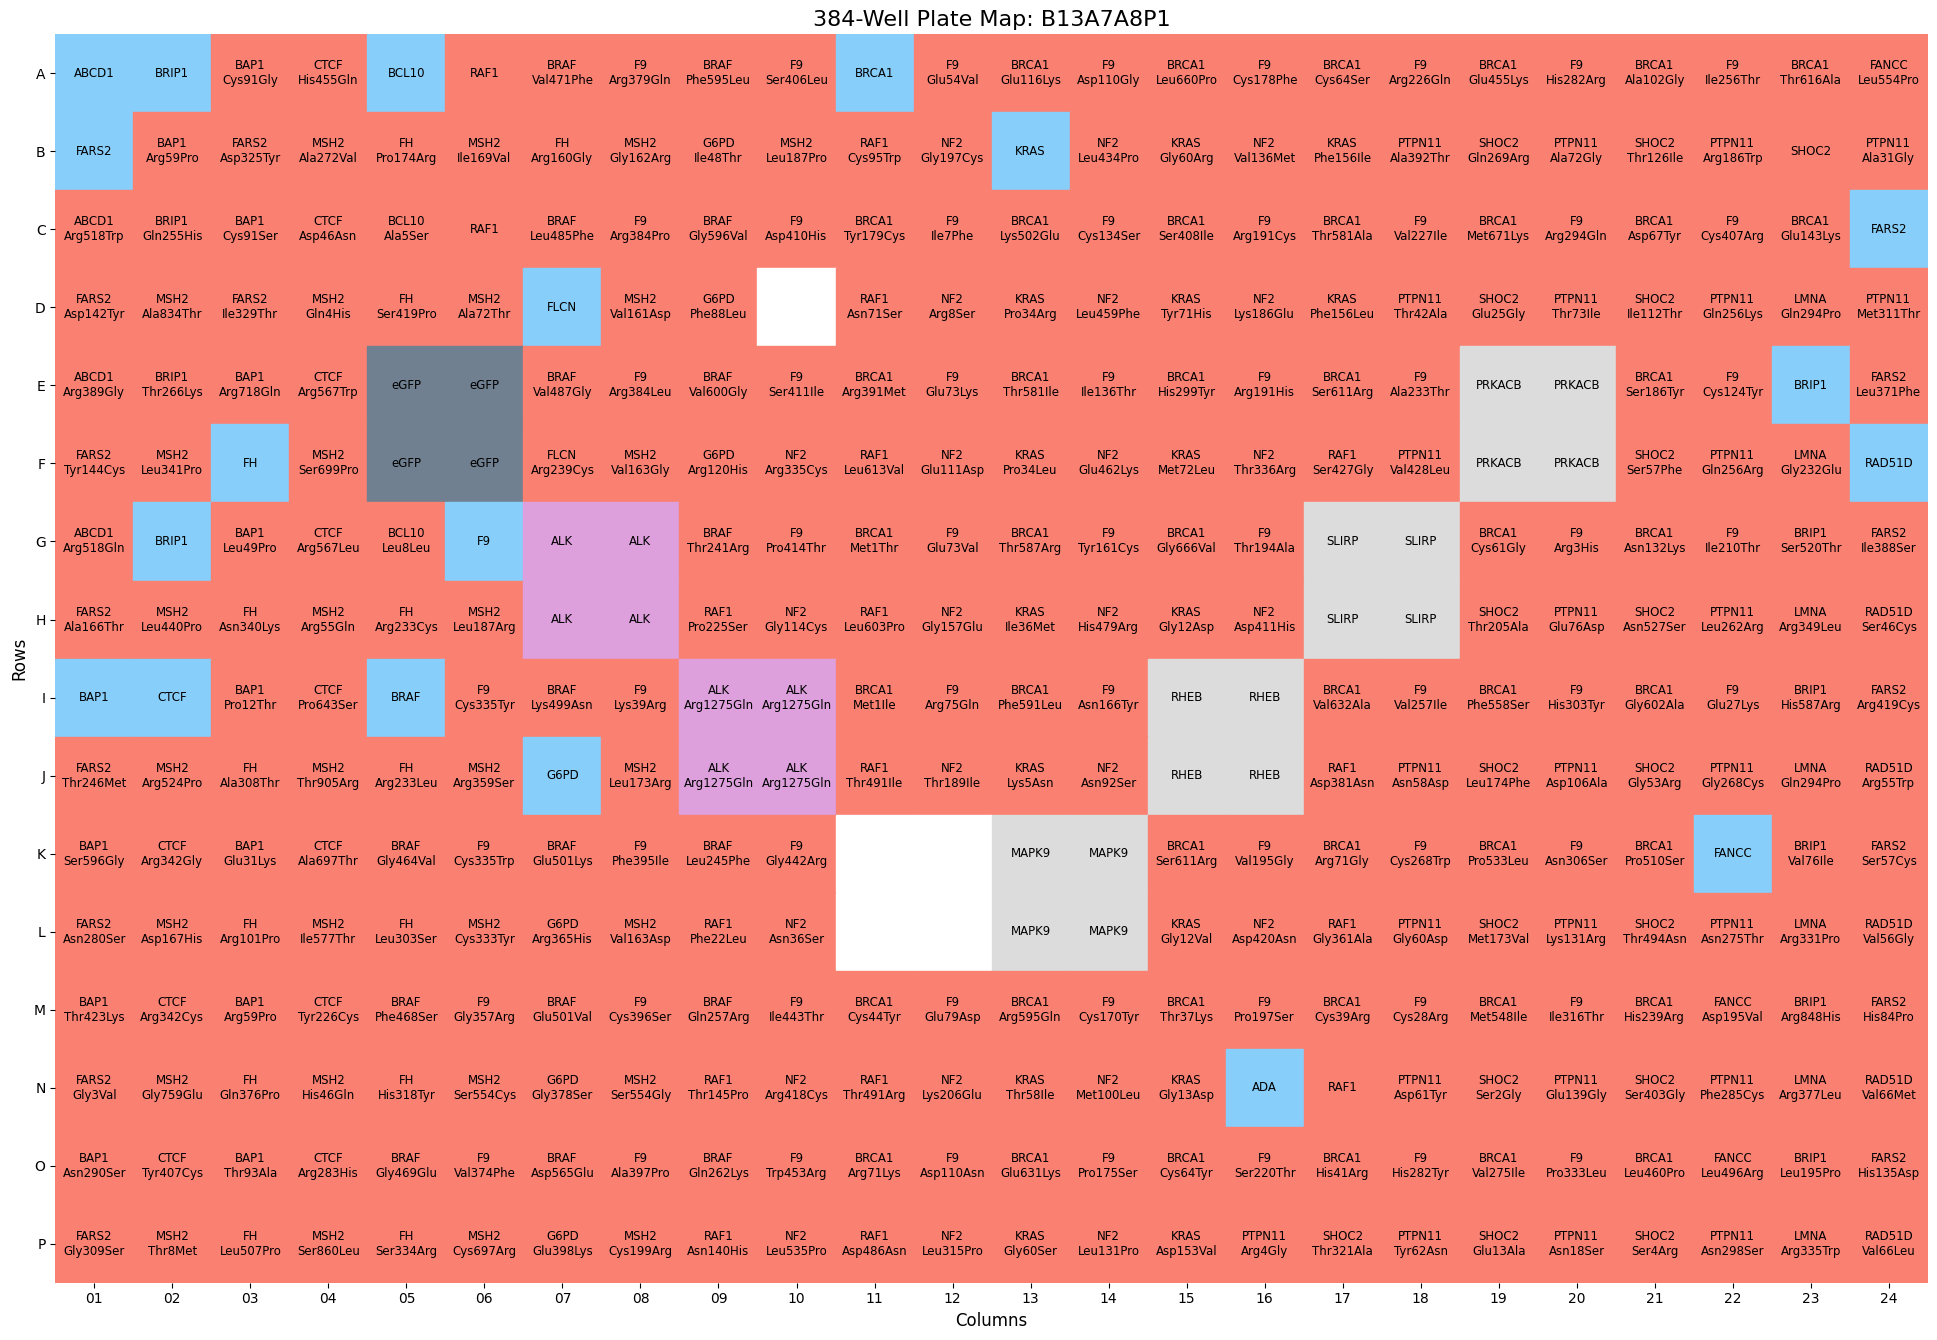

gene_allele
u32
327


In [62]:
plate_map_id = "B13A7A8P1_R1.txt"
batch_dir = "2025_01_27_Batch_13"
meta_dat_b134_corrected = pl.read_csv(os.path.join(batch_dir_out, batch_dir, "platemap", plate_map_id), separator='\t', has_header=True)
plate_grid_p1 = plot_platemap(meta_dat_b134_corrected, "B13A7A8P1")
plate_grid_p1.filter((pl.col("gene_allele")!="")&(pl.col("node_type")=="allele")).select("gene_allele").unique().count()

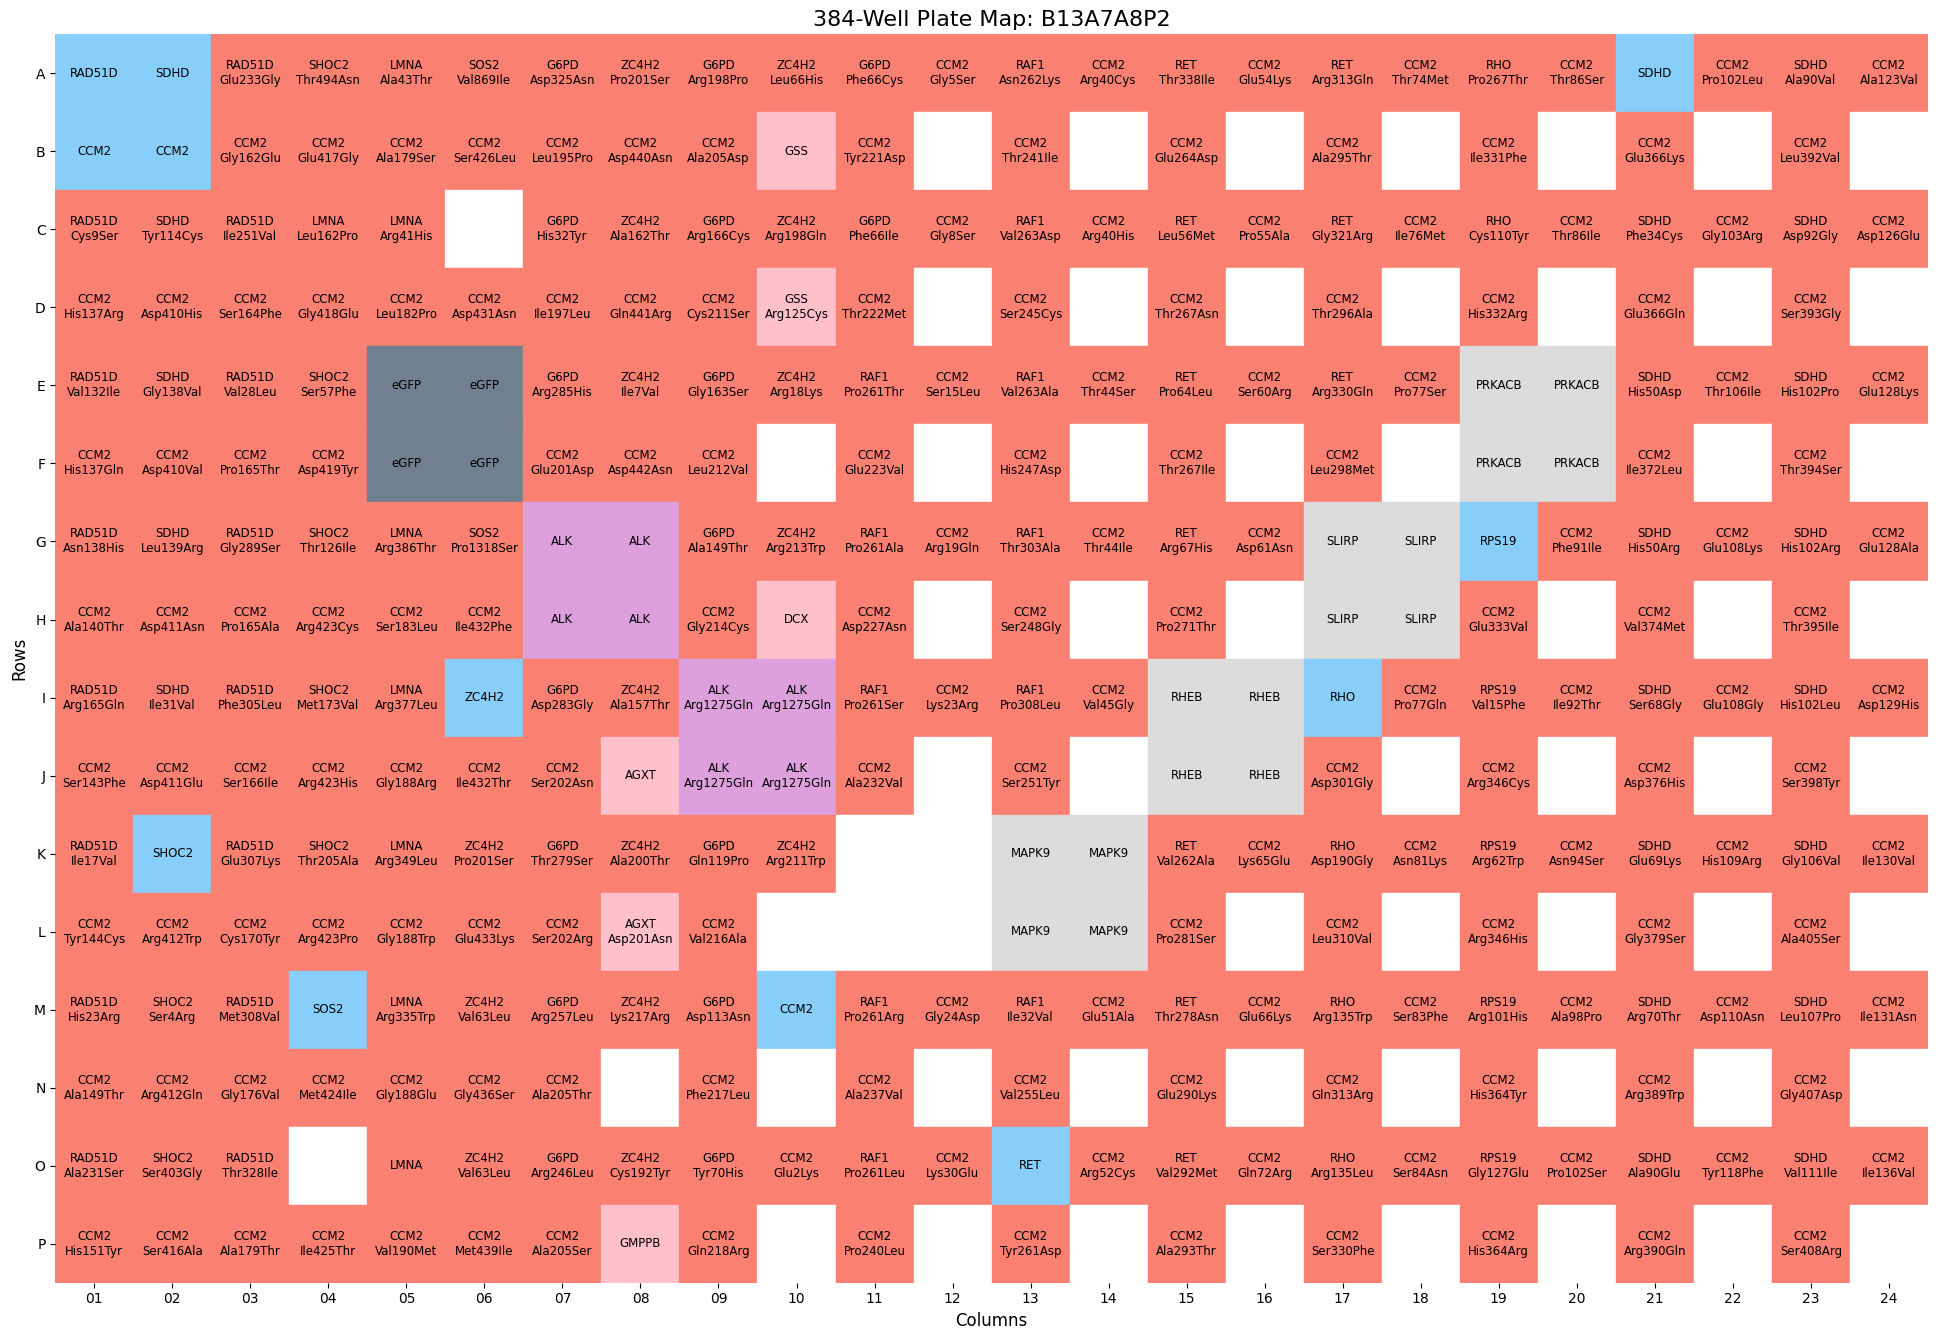

gene_allele
u32
274


In [64]:
plate_map_id = "B13A7A8P2_R1.txt"
batch_dir = "2025_01_27_Batch_13"
meta_dat_b134_corrected = pl.read_csv(os.path.join(batch_dir_out, batch_dir, "platemap", plate_map_id), separator='\t', has_header=True)
plate_grid_p2 = plot_platemap(meta_dat_b134_corrected, "B13A7A8P2")
plate_grid_p2.filter((pl.col("gene_allele")!="")&(pl.col("node_type")=="allele")).select("gene_allele").unique().count()

In [65]:
# with pl.Config(set_tbl_rows=1000):
#     display(plate_grid_p1.filter((pl.col("gene_allele")!="")&(pl.col("node_type")=="allele")).sort(by="gene_allele"))
#     display(plate_grid_p2.filter((pl.col("gene_allele")!="")&(pl.col("node_type")=="allele")).sort(by="gene_allele"))

In [66]:
alleles_on_plates = list(plate_grid_p1.filter((pl.col("gene_allele")!="")&(pl.col("node_type")=="allele"))["gene_allele"].to_list()) + \
    plate_grid_p2.filter((pl.col("gene_allele")!="")&(pl.col("node_type")=="allele"))["gene_allele"].to_list()

In [67]:
len(set(alleles_on_plates))

591

__A total of 591 unique variants was screened in this round of image batches.__